In [2]:
#импорт библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [3]:
#читаем таблицу с метрикой-скор для каждой вакансии 

vacs_metrics = pd.read_csv('vacs_metrics.csv')

In [4]:
vacs_metrics.head()

,vacancy_id_conv,metric_full,emplpyer_id
0,1,5.250818,640
1,2,5.808587,5123
2,3,2.830297,3325
3,4,5.179469,3511
4,5,5.457955,6604


In [5]:
vacs_metrics.describe()

,vacancy_id_conv,metric_full,emplpyer_id
count,55500.000000,55500.000000,55500.000000
mean,28750.169694,4.393625,4994.316342
std,16711.462112,1.430828,2882.736532
min,1.000000,-2.259488,0.000000
25%,14281.750000,3.609140,2485.000000
50%,28660.500000,4.562120,4994.000000
75%,43149.250000,5.372227,7469.000000
max,58346.000000,8.949871,9999.000000


In [6]:
#вакансии с метрикой-скор меньше трех

score_less_than_3 = vacs_metrics.query('metric_full < 3')

In [7]:
score_less_than_3

,vacancy_id_conv,metric_full,emplpyer_id
2,3,2.830297,3325
36,37,2.718547,5685
51,52,2.840717,4405
58,59,2.770307,5415
60,61,0.789023,5325
...,...,...,...
55494,58335,2.201372,7325
55495,58338,2.825501,1900
55496,58339,0.842977,2173
55497,58342,-0.628653,1110


In [8]:
# доля вакансий со скором меньше трех от всех вакансий

metric_now = round(vacs_metrics.query('metric_full < 3').shape[0] / vacs_metrics.shape[0],3)

In [9]:
metric_now

0.153

In [10]:
#читаем таблицу поисковых выдач с колонками

serps = pd.read_csv('serps.csv')

In [11]:
serps.head()

,request_id,vacancy_id_conv,city,applicant
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260


In [12]:
#выводим индекс поисковой выдачи в отдельный столбец

serps = serps.reset_index()
serps['index']= serps['index'].map(lambda x:x+1)

In [13]:
#вводим весовой коэффииент для вакансии в поисковой выдаче (порядок вакансии в поисковой выдаче/кол-во вакансий в выдаче)

serps['weight_coefficient'] = serps.groupby('request_id').index.rank() 
serps['max_rank'] = serps.groupby(['request_id']).weight_coefficient.transform('max')
serps['weight_coefficient'] = round(serps['max_rank']/serps['weight_coefficient'],3)

In [14]:
#избавляемся от вспомогательных столбцов

serps = serps[['request_id','vacancy_id_conv','city','applicant','weight_coefficient']]

In [15]:
vac_rating = serps.groupby('vacancy_id_conv', as_index=False).agg({'weight_coefficient':'sum'}) \
    .rename(columns={'weight_coefficient':'vac_rating'}).sort_values('vac_rating', ascending=False)

In [16]:
vac_rating.head()

,vacancy_id_conv,vac_rating
13564,13960,38658.806
15229,15681,32231.031
15974,16444,17932.512
33186,34321,9669.666
7635,7841,7314.243


In [17]:
vac_rating.describe()

,vacancy_id_conv,vac_rating
count,55500.000000,55500.000000
mean,28750.169694,85.399619
std,16711.462112,313.455015
min,1.000000,1.000000
25%,14281.750000,11.456000
50%,28660.500000,29.417000
75%,43149.250000,74.085000
max,58346.000000,38658.806000


In [18]:
low_rating = vac_rating.query('vac_rating<=29.4173')

In [20]:
high_rating  = vac_rating.query('vac_rating > 29.417')

In [21]:
low_rating.head()

,vacancy_id_conv,vac_rating
47453,49286,29.417
43342,44953,29.417
36485,37792,29.417
49997,52039,29.417
45319,47028,29.417


In [91]:
union_rating = vac_rating.merge(vacs_metrics, on='vacancy_id_conv')

In [94]:
low_union_rating = union_rating.query('vac_rating<=29.4173')

In [96]:
high_union_rating = union_rating.query('vac_rating > 29.4173')

<Axes: >

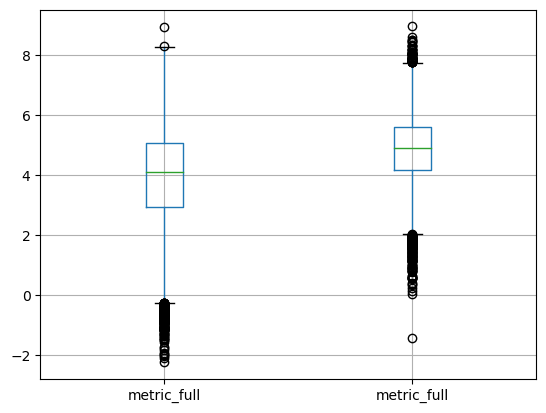

In [108]:
pd.concat([low_union_rating.metric_full, high_union_rating.metric_full], axis=1).boxplot()

In [36]:
high_rating_clear = high_rating.merge(vacs_metrics, on='vacancy_id_conv').query('metric_full > 3')

In [37]:
high_rating_clear.shape

(26498, 4)

In [38]:
low_rating_clear = low_rating.merge(vacs_metrics, on='vacancy_id_conv').query('metric_full <= 3')

In [39]:
low_rating_clear.shape

(7255, 4)

<Axes: >

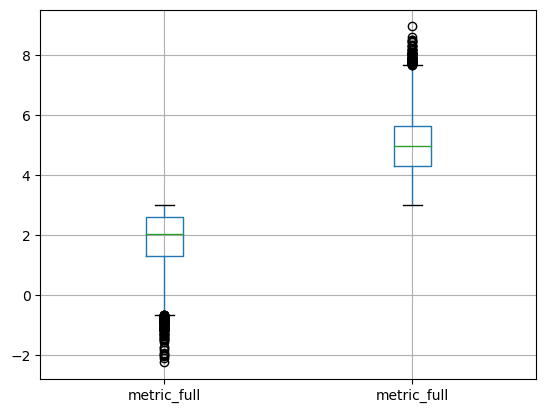

In [40]:
pd.concat([low_rating_clear.metric_full, high_rating_clear.metric_full], axis=1).boxplot()

In [41]:
control_clear = set()
for i in range(0, len(low_rating_clear.vacancy_id_conv),2):
    control_clear.add(low_rating_clear.reset_index().vacancy_id_conv[i])
while len(control_clear) < 7255:
    control_clear.add(np.random.choice(high_rating_clear.vacancy_id_conv))

In [61]:
test_clear = set()
for i in range(1, len(low_rating_clear.vacancy_id_conv),2):
    test_clear.add(low_rating_clear.reset_index().vacancy_id_conv[i])
free_high_rating_vacs = list(set(high_rating_clear.vacancy_id_conv)-control_clear)
while len(test_clear) < 7255:
    test_clear.add(np.random.choice(free_high_rating_vacs))

In [63]:
#проверка на несовпадение двух групп
control_clear&test_clear

set()

In [65]:
test_clear_df = pd.DataFrame(test_clear).rename(columns={0:'vacancy_id_conv'}).sample(frac=1).reset_index(drop=True)

In [110]:
control_clear_df

,vacancy_id_conv
0,15840
1,20080
2,47305
3,23936
4,19965
...,...
7250,75
7251,14925
7252,37427
7253,108


In [66]:
control_clear_df = pd.DataFrame(control_clear).rename(columns={0:'vacancy_id_conv'}).sample(frac=1).reset_index(drop=True)

In [67]:
control_metric_clear = control_clear_df.merge(vacs_metrics, on='vacancy_id_conv')

In [74]:
control_metric_clear.metric_full.var()

3.3575292506469276

In [69]:
test_metric_clear = test_clear_df.merge(vacs_metrics, on='vacancy_id_conv')

In [73]:
test_metric_clear.metric_full.var()

3.284738739083842

In [118]:
MDE = (-(-2.802)*((test_metric_clear.metric_full.var()+control_metric_clear.metric_full.var())/7255)**0.5) *100

In [119]:
MDE

8.478277347527246